# Overview

<img src="https://www.researchgate.net/profile/Shilad_Sen/publication/221607721/figure/fig1/AS:305580804722702@1449867549680/Intermediary-entities-center-relate-user-to-recommended-item.png" width=500>

**General Workflow**
- Generate features from user behavior (indirect) / user attributes (direct) for pairs of $(u,i)$
    - Behavior weighing (view, click, purchase)
    - Behavior time (recent or past)
    - Behavior frequency
    - Item popularity (more popular, less important)
    
    
- Apply algorithms (as in following sections), and get candidate list of items
    - For a give user feature vector, retrieve $(item, weight)$
    - There can be multiple tables (e,g., one table for CF, one-table for content-based) or (e.g., one table for browse, one table for click)

- Filtering based on business rules
    - For example, only recommend new products
    
    
- Ranking by some criterias
    - For example, variety


# Content-basd Recommendation

- Different from item-based CF, where similarity is calculated based on user-item-interactions
- Calculate **similarity** with **items** of **ONE user**
- Similarity is calculated based on item attribute (for example, location, price, cuisine, etc.)
    - Output: An item space with defined distance
- One model for one user; No interaction between users


# Memory-based CF

## Load some sample dataset

In [2]:
%load_ext autoreload
%autoreload
import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cosine
from scipy import sparse
from script import cf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Import Example Data**

Input data includes:
- User Info (sex, income)
- Item Info (BOW, TF-IDF)
- User-Item Interaction
    - active/explicit: rating
    - passive/implicit: clickstream analysis


Input data dimension
- Can be million+ user
- Can be 10k+ products

Load example data

In [2]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/ml-100k/u.data', sep='\t', names=header)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


In [4]:
df_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    df_matrix[line[1]-1, line[2]-1] = line[3]
df_matrix.shape

(943, 1682)

## Define Cosine Similarity
$Similarity = cos(\theta) = \frac{\mathbf A \cdot \mathbf B }{||\mathbf A|| \ ||\mathbf B|| }$

In [5]:
###
user_similarity = np.zeros((n_users, n_users))
for i in range(n_users):
    u= df_matrix[i,]
    for j in range(n_users):
        v= df_matrix[j,]
        user_similarity[i,j] = np.dot(u,v) / (np.linalg.norm(u,ord=2) * np.linalg.norm(v,ord=2)) 

In [6]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(df_matrix, metric='cosine')
user_similarity.shape

(943, 943)

In [7]:
item_similarity = pairwise_distances(df_matrix.T, metric='cosine')
item_similarity.shape

(1682, 1682)

## Evaluation metrics

- Rating prediction: RMSE, MAE
- Top-k rating precision: Precision, Recall, AUC
    - % of the top-k recommendations that were actually used by user
- Possible benchmark model: global top-k recommendations

## Prediction

### User-Item Filtering
- Users who are similar to you also liked ...
- Prediction for user **k** for movie **m** :

- Prediction = User **k** bias + adjustmemnt from similar user
    - $ \hat{x}_{k,m} = \bar x_k + \frac{\Delta}{Norm}  $


- Adjustment = (similarity with another user) * (rating of another user - bias of another user)
    - $ \Delta = \sum_{k_0}UserSim(k, k_0) \cdot (x_{k_0, m} - \bar x_{k0})$

    - $ Norm = \sum_{k_0}|UserSim(k, k_0)|$


In [8]:
%%writefile ./script/cf.py
import numpy as np

def ui_predict(ratings, similarity):
    all_user_mean = ratings.mean(axis = 1)
    ratings_diff = (ratings - all_user_mean[:, np.newaxis]) # (943, 1682)
    
    adjust = similarity.dot(ratings_diff)
    norm = np.array([np.abs(similarity).sum(axis=1)]).T

    pred = all_user_mean[:, np.newaxis] + adjust / norm
    
    return pred


Overwriting ./script/cf.py


In [9]:
from script.cf import *
cf.ui_predict(df_matrix, user_similarity).shape

(943, 1682)

### Item-Item Filtering
Users who liked this item also liked ...
- $ \hat{x}_{k,m} = \frac{\sum_{m_0}ItemSim(m, m_0)}{Norm}  \cdot x_{k, m_0}$
   
How to understand $ItemSim(m, m_0)$:
- Dot product: number of users who like both item $m$ and item $m_0$ (If input matrix is not rating)
- $ItemSim(m, m_0)$: added normalization to [0,1]

Result:
- Each item $m_0$ is contributing to rating of the target item $m$
<img src="http://n.sinaimg.cn/sinacn23/279/w640h439/20180715/cbd7-hfkffak1630519.jpg" width=500>

In [10]:
%%writefile -a ./script/cf.py

def ii_predict(ratings, similarity):
    norm = np.array([np.abs(similarity).sum(axis=1)])
    pred = ratings.dot(similarity)  / norm
    return pred

Appending to ./script/cf.py


In [11]:
cf.ii_predict(df_matrix, item_similarity).shape

(943, 1682)

## Comparison between user-based and item-based
|User-based       | Item-based           | 
| ------------- |:-------------:| 
| more socialized      | more personalized | 
| fro example: news | for example: books|
| update user-similarity matrix| update item-similarity matrix|
| number of user << number of items | number of user >> number of items|
| Not interpretable | Interpretable|
| Cold starting: No problem for new items (after 1 action) | Cold starting: no problem for new users (after one action)|

# Model-Based CF 

## Matrix Factorization or Latent Factor Model
Singular-Value-Decomposition

<img src="https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/figures/BLOG_CCA_4.png" width="400">


- $M = U \times \Sigma \times V^T  $ Note: $\Sigma$ can be multipled to U or V
- Con: need default value for missing value in rating matrix
    - For like (0/1) or implicit feedback: 
    - 1) balanaced negative samples + postive samples
    - 2) draw negative samples from popular items 
    
    
- U and V are low-dimention latent vectors (Embeddings) for users and movies. 
    - How to interpret this dimensions? Genres (i.e., users' preference for Genre $k$ and a given book's weight on genre $k$)
    - 
    
    
- Alternative approach: $Min(L) = \sum_{i,j}{(u_i v_j - x_{ij})^2} + Regularization (u,v)$
    - Solved by SGD
   
   
    

In [52]:
u, s, vt = svds(df_matrix, k = 20)
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

<img src="https://cdn-images-1.medium.com/max/1760/1*2i-GJO7JX0Yz6498jUvhEg.png" width="600">


## Other methods: 
- Probabilistic factorization (PMF)
    * P = dot_product(i,j) + User_i_bias + movie_j_bias + intercept
- Non-negative factorization (NMF)

- Weighted rankings from two models
- Cascade: 1) Accurate model -> rough rank; 2) 2nd one to refine
- Treat collaborative factors as extra feature for content-based model

## Comparison with memory-based CF
- No need to store user-user ($ U \times U $) or Item-Item ($ I \times I$) similarity matrix in memory. The memory requirement is $F \times (U + I)$
- Matrix calculation on real-time is hard for large number of items, so mainly for off-line. Time complexity can be $F \times U \times I$. While memory-based method just needs a look-up table.
- Hard to interpret

# Model-Based CF - Deep Learning

- Main difference with SVD
    - Don't require orthogonal vectors as in SVD
    - Learn the embedding by itself
    - Allows non-linearity instead of just dot product
    
    
- Extra benefits
    - Can incoporate additional features like user profile
    

## Model Types

### Basic Idea V1
- One-hot encoding for user i
- Hiddern layer: Embedding layer for users
    - Weights: latent vector for users
    
    
- Output layer: output ratings for each item j
    - Weights: latent vector for movies
    
    
###  Basic Idea V2
- One-hot encoding for user i
- Hiddern layer: Embedding layer for users
    - Weights: latent vector for users
    
    
- One-hot encoding for item j
- Hidden layer: output ratings for each movie j
    - Weights: latent vector for movies


- More hidden layers

<img src="https://image.slidesharecdn.com/neuralcollaborativefiltering-170528094418/95/neural-collaborative-filtering-9-638.jpg?cb=1496201763" width="600">
    

###  A lot of other DL network types    

Example: https://arxiv.org/abs/1708.05031
<img src="https://nipunbatra.github.io/blog/2017/neumf.png" width="600">



## Example in Keras

In [54]:
import keras
from IPython.display import SVG
from keras import Model
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense, Dropout
from keras.utils.vis_utils import model_to_dot

### Model Params

In [55]:
n_latent_factors = 20

### Define Model

In [56]:
item_input = Input(shape = [1], name = 'Item-input')
item_embedding = Embedding(n_items, n_latent_factors, name = 'Item-embedding')(item_input)
item_flat = Flatten(name = 'Item-flatten')(item_embedding)

In [57]:
user_input = Input(shape = [1], name = 'User-input')
user_embedding = Embedding(n_users, n_latent_factors, name = 'User-embedding')(user_input)
user_flat = Flatten(name = 'User-flatten')(user_embedding)

**Option1**

In [58]:
dotprod = Dot(axes=1, name='DotProduct')([item_flat, user_flat])
model = Model([item_input, user_input ], dotprod)
model.compile('adam', 'mean_squared_error')

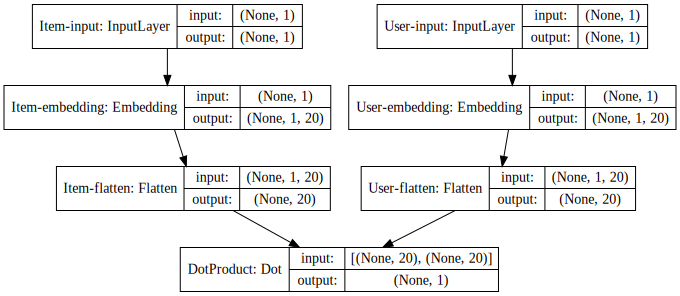

In [59]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

**Option2**

In [63]:
concatenate = Concatenate(name='Concatenate')([item_flat, user_flat])
dropout = Dropout(0.2,name='Dropout')(concatenate)
dense_1 = Dense(20,activation='relu', name='FC-1')(dropout)
activation = Dense(1, activation='relu', name='Activation')(dense_1)
model = Model([item_input, user_input ], activation)
model.compile('adam', 'mean_squared_error')

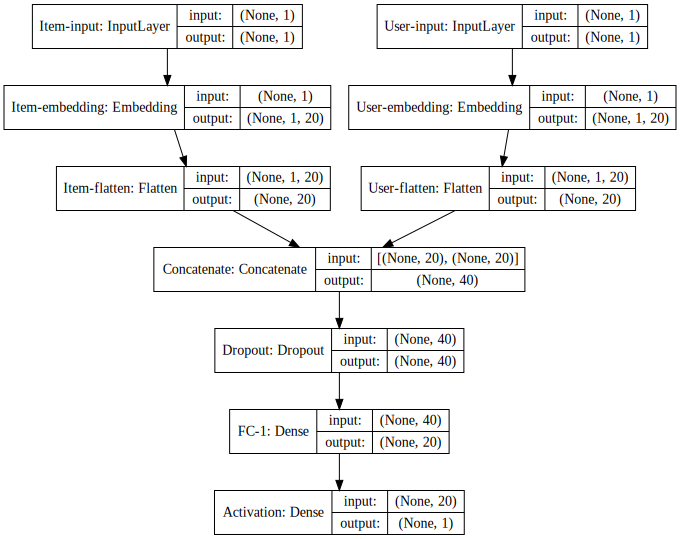

In [64]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

### Model Training

In [65]:
#https://keras.io/models/model/
model.fit(x = [df.item_id - 1, df.user_id - 1], 
          y = df.rating, 
          epochs = 15, 
          verbose = 2, 
          validation_split = 0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/15
 - 4s - loss: 1.5278 - val_loss: 0.9136
Epoch 2/15
 - 3s - loss: 0.9126 - val_loss: 0.8956
Epoch 3/15
 - 3s - loss: 0.8964 - val_loss: 0.8882
Epoch 4/15
 - 3s - loss: 0.8809 - val_loss: 0.8799
Epoch 5/15
 - 3s - loss: 0.8614 - val_loss: 0.8652
Epoch 6/15
 - 3s - loss: 0.8486 - val_loss: 0.8639
Epoch 7/15
 - 3s - loss: 0.8381 - val_loss: 0.8644
Epoch 8/15
 - 3s - loss: 0.8255 - val_loss: 0.8608
Epoch 9/15
 - 3s - loss: 0.8156 - val_loss: 0.8549
Epoch 10/15
 - 3s - loss: 0.8033 - val_loss: 0.8568
Epoch 11/15
 - 3s - loss: 0.7958 - val_loss: 0.8511
Epoch 12/15
 - 3s - loss: 0.7857 - val_loss: 0.8489
Epoch 13/15
 - 3s - loss: 0.7771 - val_loss: 0.8513
Epoch 14/15
 - 3s - loss: 0.7703 - val_loss: 0.8451
Epoch 15/15
 - 3s - loss: 0.7656 - val_loss: 0.8548


### Extract Weight

In [66]:
model.get_layer(name='User-embedding').get_weights()[0].shape

(943, 20)

In [67]:
model.get_layer(name='Item-embedding').get_weights()[0].shape

(1682, 20)

# Possible A/B Test

https://medium.com/nikeengineering/serving-athletes-with-personalized-workout-recommendations-285491eabc3d

- Group: 
50 percent baseline as the Champion 
50 percent Collaborative Filtering 

- KPI: 
User actually start a workout that shown from a recommended section


# Ranking Algorithms

- Top-K ranking problem instead of rating prediction problem
- More consistent with practical user needs

## How to evaluate a ranking system

## Recall and Precision
- Given user $u$, the model generates a recommendation set $R$ and true set (where the user likes/rates) $T$
- $Recall = \frac{R \cap T}{T}$
- $Precision = \frac{R \cap T}{R}$

<img src="https://qph.ec.quoracdn.net/main-qimg-18cd74b05b850406e1c01b76b1cb8fd6?convert_to_webp=true" width="400">


### AP (Average Precision)

$Average Precision = \frac{\sum_{k=1}^{N}{P(k) * rel(k)}}{K} $
- $P(k)$ is precision of first k results
- $rel(k)$ is binary value 0/1
- $K$ is total number of relevant items

<img src="https://slideplayer.com/2295316/8/images/4/Mean+Average+Precision.jpg" width="400">

### Normalized Discounted Cumulative Gain

- The premise of DCG is that highly relevant documents appearing lower in a search result list should be penalized as the graded relevance value is reduced logarithmically proportional to the position of the result.
- Note: rel(i) here can be any value instead of binary

<img src="https://image.slidesharecdn.com/colmujsktqk4sh7faxcd-signature-f4a0831a458d6bbb78c09b1a397c3517fe8a2c82e9751f039f832a3be97b108f-poli-141208101339-conversion-gate02/95/florian-douetteau-dataiku-7-638.jpg?cb=1418033719" width="400">

https://en.wikipedia.org/wiki/Discounted_cumulative_gain

## Coverage
<img src="https://slideplayer.com/10441443/35/images/7/Coverage+Measure+the+ability+of+recommender+system+to+recommend+all+items+to+users.+Entropy%2C+Gini+Index..jpg" width=400>

<img src="https://image.slidesharecdn.com/divers-111026095821-phpapp01/95/towards-diverse-recommendation-72-728.jpg?cb=1319623189" width=400>

## Modelling Approach

- Pointwise
    - Given user u and item i, predict score x
    - Not necessary, since the score is not important; ranked list is important.
    - Actually solving a *regression* problem
    - The relationships between documents sometimes not considered
    - Usually: regression, classification, etc
    
<img src="https://image.slidesharecdn.com/l2rrecysystutaly-final-131012040539-phpapp01/95/learning-to-rank-for-recommender-systems-acm-recsys-2013-tutorial-40-638.jpg?cb=1381555055" width="400">
    
    
- Pairwise
    - Goal is to correctly determine a>b or a<b for each document pair
    - The scale of difference is ignored

<img src="https://image.slidesharecdn.com/l2rrecysystutaly-final-131012040539-phpapp01/95/learning-to-rank-for-recommender-systems-acm-recsys-2013-tutorial-46-638.jpg?cb=1381555055" width="400">

- Listwise
    - Directly optimize final performance metric
    - More complicated modelling
    
<img src="http://baogege.info/img/learning-to-rank-for-recommender-system/listwiseltrrs.png" width="400">    


# Cold Starting

For new users:
- Provide most popular items
- Provide results based on demographic attributes (gender, age, etc)
- Ask users to provide feedback on some items before providing recommendation


For new items:
- If using user-based CF, then as long as some user finds the items from other sources, it will be spread among users
- If using item-based CF, then have to use item content to calculate item similarity, otherwise it will never be presented to users
    - Calculate item-similarity by vectorizing items
    - A strong feature would actually help content-based recommendation out-perform CF
    
- Some examples of similarity w/o user behavior history
    - keyword vector of an item title with the help of NER
    - TF-IDF of a text
    - LDA topic modelling (use topic vector to calculate similarity)
     

# CTR (Click-Through Rate) Prediction

## Problem Statement

Given (user, item, context): predict click = 0/1
- Goal: $P(Click=1|User, Item, Context)$
- Difference: in recommendation system and in online ad. 
- The former mainly cares about ranking, while the latter cares about accuracy, because it contributes to revenue.

## Modelling Approach - Traditional

- Logistic Regression + Feature Engineering (Linear Model)
    - Advantage: simple model, good at dealing with discrete features
    - Main problem: feature combination, high-order interaction, only linear relationship --> (**Fix**: FM)
    - For example: gender and clothes type; manual interaction is required
    
    
- GBDT
    - Advantage: good at dealing with continous features
    - Capable of doing some feature combination (more than 2 orders)
    - Capable of doing some feature selection
    
    
- Degree-2 Polynomial Mappings 
    - Combine features by $y(X)=w_0 + \sum_{i=1}^{N}{w_{1i}x_i} + \sum_{i=1}^{N}\sum_{j=i+1}^{N}{w_{2ij}x_ix_j} $, where N is number of features
    - Sparse data
    - High dimension: $O(n^2)$
    - Make trivial prediction on those unseen pairs
    
<img src="http://ailab.criteo.com/wp-content/uploads/2017/03/Screen-Shot-2017-02-10-at-11.12.46-AM-789x121.png" width="400">   


- Known: for matrix W, and a large K, $W \approx VV^T$, i.e., $w_{ij} \approx <v_i, v_j>$
- Factorization Machine (FM)
    -  $y(X)=w_0 + \sum_{i=1}^{N}{w_{1i}x_i} + \sum_{i=1}^{N}\sum_{j=i+1}^{N}{<v_i, v_j>x_ix_j} $
    - $v_i, v_j - R^{N \times K}$, latent vector for feature i and j with embedding length $K$
    - Reasonable prediction for unseen pairs
    - Lower dimension: $O(N \times K)$

    
<img src="http://ailab.criteo.com/wp-content/uploads/2017/03/Screen-Shot-2017-02-10-at-11.12.53-AM-768x301.png" width="400">   



- Field Factorization Machine (FFM)
    - Split the original latent space into many “smaller” latent spaces,  and depending on the fields of features, one of them is used.
    - For example: weather, location, gender; intuitively, they should have different interactions
    - Note: slower than FM
    - $y(X)=w_0 + \sum_{i=1}^{N}{w_{1i}x_i} + \sum_{i=1}^{N}\sum_{j=i+1}^{N}{<v_{i, f_j}, v_{j, f_i}>x_ix_j} $
<img src="http://ailab.criteo.com/wp-content/uploads/2017/03/Screen-Shot-2017-02-10-at-11.13.03-AM-768x230.png" width="400"> 


- GBDT + LR (Mixed)
    - GBDT transforms features, reduced dimensions, combined attributes
    - The leaves serve as new input features for LR
<img 
    - Alternative: use GBDT for continous variables, get $gbdt(X_{continuous})$, and concatenate with $X_{discrete}$ to get final $\mathbf X$, and feed into LR.
    
    
<img src="https://raw.githubusercontent.com/PnYuan/Practice-of-Machine-Learning/master/imgs/Kaggle_CTR/gbdt-lr/gbdt-lr_2.png" width="500">


## Modelling Approach - Deep Learning

- Main Advantage
    - High-order interaction is possible by nature
    - Can be extended into figures/texts
- Main characteristic
    - Shallow part of model (yes/no)
    - Stack part of model
        - Concentenate
        - Bi-Interaction
    - Start: Embedding layer
    - End: FC layer
    
<img src="https://pic2.zhimg.com/80/v2-627974c0bb215cb6404e9ee51bbb5752_hd.jpg" width="700">

ref: https://github.com/hhlisme/Daily

- Describe Factorization Machine (FM) as deep learning network

<img src = "https://pic3.zhimg.com/80/v2-3d5201396f213cf78c61c68c2e8c77a5_hd.jpg" width = "500">

### Wide and Deep
- Memorization: learning the directly relevant frequent co-occurrence of items;
- Generalization: improving the diversity exploring new items combinations that have never or rarely occurred in the past.
- **Wide/Shallow**: LR for categorical variables --> Memorization
- **Deep/Stack**: DNN for continous/categorical variables --> Generalization
<img src="https://1.bp.blogspot.com/-Dw1mB9am1l8/V3MgtOzp3uI/AAAAAAAABGs/mP-3nZQCjWwdk6qCa5WraSpK8A7rSPj3ACLcB/s1600/image04.png" width="800">
---
<img src="http://edarchimbaud.github.io/img/2016-11-22-wide-and-deep-learning-for-recommender-systems/Screenshot%20from%202016-11-22%2021-07-22.png" width="600">



- An example from https://zhuanlan.zhihu.com/p/37823302

<img src="https://pic4.zhimg.com/80/v2-e440f72e8bf2a4be2274235d481d4f63_hd.jpg" width="600">

**Network structure**

Part 4: Wide Part, including position bias, some categorical features to enable memorization

Part 1: Deep Part, including categorical features
- User ID / Item ID / Area ID
- Some discretized continuous features
- Missing / Lower frequency IDs treated as separate value

Part 2: Deep Part, including continuous features
- Some statistics
- Text
- Image

Part 3: FC, Activation layer, etc.

**List/Type of features**
- User Characteristic
    - Demographic
    - Behavior, preference, activeness
- Business Characteristics
    - Type, city, star, etc
    - Image
- Query
    - Tokens, similarity
- Context
    - Time, distance, competition
    - Position bias

**Key feature: user behavior**
- Real time user behavior
    - Clicked Business (C_P)
    - Ordered Business (O_P)
    - Queries (Q)
    - Sortings (S)
    - Business Characteristic (C_Type, O_Type, C_Loc, O_Loc)
    
    
- Problem: Sparsity of C_P, O_P, Q, S
- Fix: separate model to describe **USER** based on user behavior 
    - Predict next time t user behavior based on LTSM
    - Doc2Vec to get embedding of a user based on behaviors
    - Topic modelling
    - Serve as continous feature in Part 2


- Extra
    - Statistics for different types of behaviors, for example, conversion rate
    - Paattern/Series of behaviors (A-B-C)
 

### Deep FM
- Ref: https://www.ijcai.org/proceedings/2017/0239.pdf
- FM and Deep parts shares the same inputs; In wide&deep, the two parts are independent
- Compared with wide&deep based on manually created features, Deep FM contains the inner product of feature latent vectors (automatically)
- Red arrow means 1 weight
- $y_{DeepFm}=sigmoid(y_{FM}+y_{DNN})$

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/151313065d71b49dbf07289c002c887d7b5a0a6b/1-Figure1-1.png" width="600">



### Neural Factorization Machines (NFM)

Below is the deep part of NFM. Difference with Deep FM:

- In DeepFM: concatenation increases number of parameters, while here bi-interaction reduces complexity
- In NFM: sum of element-wise product loses informaion, but reduced parameters


<img src = "https://image.slidesharecdn.com/readinggroup-nfm-20170312-180312053718/95/reading-group-nfm-20170312-14-638.jpg?cb=1520833085" width = "700">



### NFFM

<img src = "https://pic3.zhimg.com/80/v2-9e58e4631ab5be2bce602df2f3d1194c_hd.jpg" width = "450">

## Some feature engineering issues


- For continuous variables
    - standardize for NN
    <img src="https://pic1.zhimg.com/80/v2-d98d393fe36b70564d39a3764c45b4f3_hd.jpg" width="500">
    
    - discretize for LR
    
    
    
- For discrete variables
    - One-got encoding
    - Text: BoW(n-gram), TF-IDF
    


# Reference
- https://arxiv.org/pdf/1606.07792.pdf
- https://www.slideshare.net/kerveros99/deep-learning-for-recommender-systems-recsys2017-tutorial?from_action=save
- https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed
- https://www.slideshare.net/microlife/recommender-systems-contentbased-and-collaborative-filtering
- https://www.slideshare.net/LadislavPeska/towards-recommender-systems-for-police-photo-lineup?next_slideshow=1
- https://nycdatascience.com/blog/student-works/capstone/metarecommendr-recommendation-system-video-games-movies-tv-shows/
- https://www.researchgate.net/publication/317558508_Item_Silk_Road_Recommending_Items_from_Information_Domains_to_Social_Users?enrichId=rgreq-ea35906fbd73392cb2fd6212acddf950-XXX&enrichSource=Y292ZXJQYWdlOzMxNzU1ODUwODtBUzo2MDM1NDY3NDc2ODY5MThAMTUyMDkwODE2NjY0OQ%3D%3D&el=1_x_3&_esc=publicationCoverPdf
- https://www.jianshu.com/p/005a4e6ac775


Ref: 
- https://pnyuan.github.io/blog/ml_practice/Kaggle%E6%BB%91%E6%B0%B4%20-%20CTR%E9%A2%84%E4%BC%B0%EF%BC%88GBDT-LR%EF%BC%89/
- http://ailab.criteo.com/ctr-prediction-linear-model-field-aware-factorization-machines/
- http://kubicode.me/2018/02/23/Deep%20Learning/Deep-in-out-Factorization-Machines-Series/
- https://zhuanlan.zhihu.com/p/37823302